### Setup Model

In [ ]:
import torch, requests, math
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoProcessor, Qwen2_5_VLForConditionalGeneration, BitsAndBytesConfig

c:\Users\namth\anaconda3\envs\lung_caption_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ----------------------------
# 0) เตรียมอุปกรณ์
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [16]:
# ----------------------------
# 1) โหลดโมเดล + โปรเซสเซอร์
# ----------------------------

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
)

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-3B-Instruct",
#     dtype="auto",
#     device_map="auto",
#     trust_remote_code=True,
#     offload_folder="offload",
#     quantization_config=bnb_cfg,
#     output_attentions=True, # attention layer
# ).eval()

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct",
    trust_remote_code=True,
    quantization_config=bnb_cfg,
    device_map={"": 0},                 # <<< บังคับลง GPU0 ทั้งโมเดล
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,         # ให้ตรงกับ compute_dtype ด้านบน
    output_attentions=True,
    output_hidden_states=True
    # ไม่ใส่ offload_folder
).eval().cuda()

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.47s/it]


In [28]:
# ----------------------------
# 2) โหลดภาพทดสอบ + คำสั่ง
# ----------------------------

# url = "https://radiologybusiness.com/sites/default/files/assets/articles/4996132.jpg"
# image = Image.open(BytesIO(requests.get(url, timeout=15).content)).convert("RGB").resize((224, 224))

file_path = "./Progress Presentation Picture/2nd/5/Original.jpg"

# เปิดไฟล์จาก local
image = Image.open(file_path).convert("RGB").resize((224, 224))

messages = [{
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": "Describe this image."}
    ],
}]

In [29]:
# ----------------------------
# 3) Inference ให้เห็นผลข้อความจริง
# ----------------------------

chat_text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# สร้าง batch inputs (ทั้งข้อความ+ภาพ) สำหรับ generate
inputs = processor(
    text=[chat_text],
    images=[image],
    videos=None,
    padding=True,
    return_tensors="pt",
)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

with torch.inference_mode():
    gen_ids = model.generate(
        **inputs,
        max_new_tokens=16,
        do_sample=False,        # deterministic
        use_cache=True,
    )

# ตัด prompt ออก เหลือเฉพาะที่โมเดลพูดต่อ
trimmed = [out[len(inp):] for inp, out in zip(inputs["input_ids"], gen_ids)]
texts = processor.batch_decode(trimmed, skip_special_tokens=True)
print("Model output:", texts[0].strip())

Model output: The image depicts a body of water with gentle waves and ripples. The water


1) Model output: This image is an X-ray of the chest, which is commonly used to examine
2) Model output: This image is a chest X-ray, which is used to examine the lungs and
3) Model output: This image is an X-ray of the chest, which is commonly used to diagnose
4) Model output: The image shows a cat with a distinctive orange coat and a black mask around its
5) Model output: The image depicts a body of water with gentle waves and ripples. The water

### Visualize Feature Map BUT Attention layer

In [30]:
# ----------------------------
# 4) ดึง Visual Attention จาก Vision Tower (ViT)
#    - ใช้พิกเซลจาก image_processor โดยตรง
#    - ขอ output_attentions=True เพื่อดึงแผนที่ attention ทุกเลเยอร์
# ----------------------------

with torch.inference_mode():
    out = model(
        **inputs,
        output_attentions=True,
        return_dict=True,
        use_cache=False
    )

attentions = out.attentions

print(type(attentions))
print(len(attentions))      # จำนวนเลเยอร์
print(attentions)

<class 'tuple'>
36
(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.5156e-01, 1.4844e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [7.1777e-02, 2.5000e-01, 6.7969e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [5.2643e-04, 1.9455e-04, 8.6975e-04,  ..., 1.2891e-01,
           0.0000e+00, 0.0000e+00],
          [6.9809e-04, 1.9932e-04, 6.9809e-04,  ..., 4.6289e-01,
           8.0566e-02, 0.0000e+00],
          [8.7738e-04, 6.8283e-04, 2.3804e-03,  ..., 6.1279e-02,
           1.6699e-01, 5.8203e-01]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.6953e-01, 7.3047e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [8.9645e-04, 1.7944e-02, 9.8047e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.2016e-04, 4.4346e-05, 4.43

In [31]:
# ลองเลือกมาเลเยอร์เดียว

attn_2 = attentions[2]

print(type(attn_2))
print(len(attn_2))
# print(attn_2)

<class 'torch.Tensor'>
1


In [32]:
layer_idx_list = [0, 15, 35]

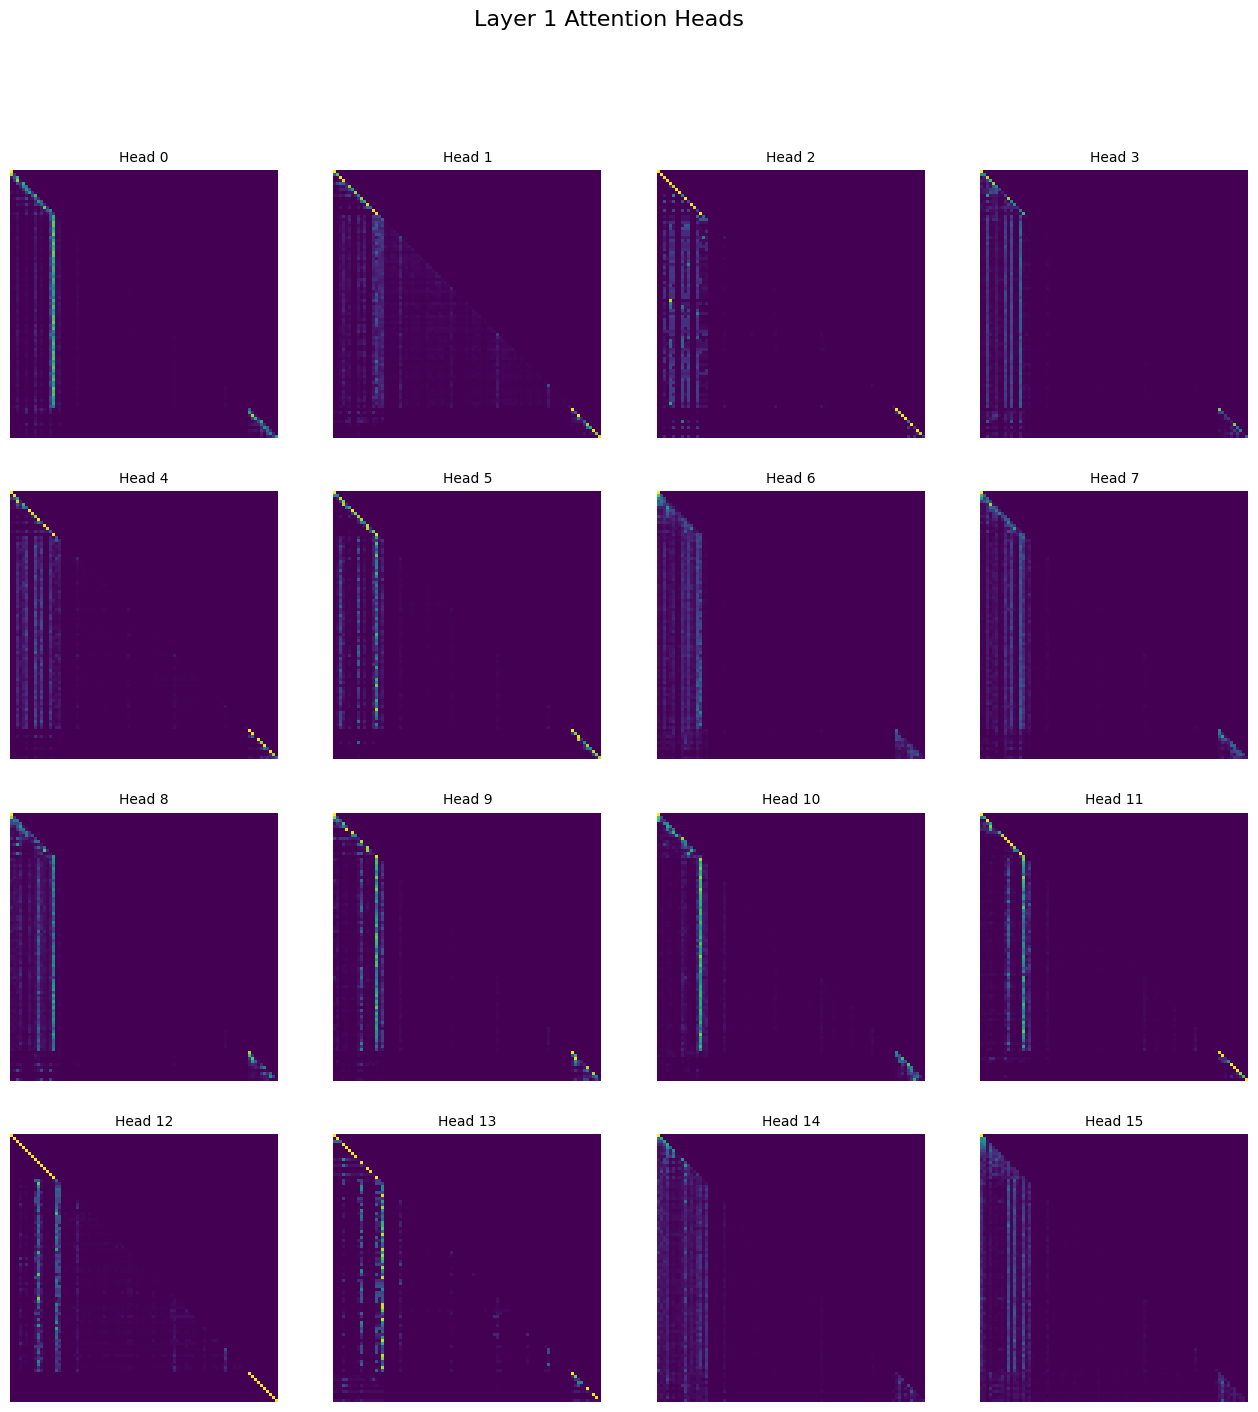

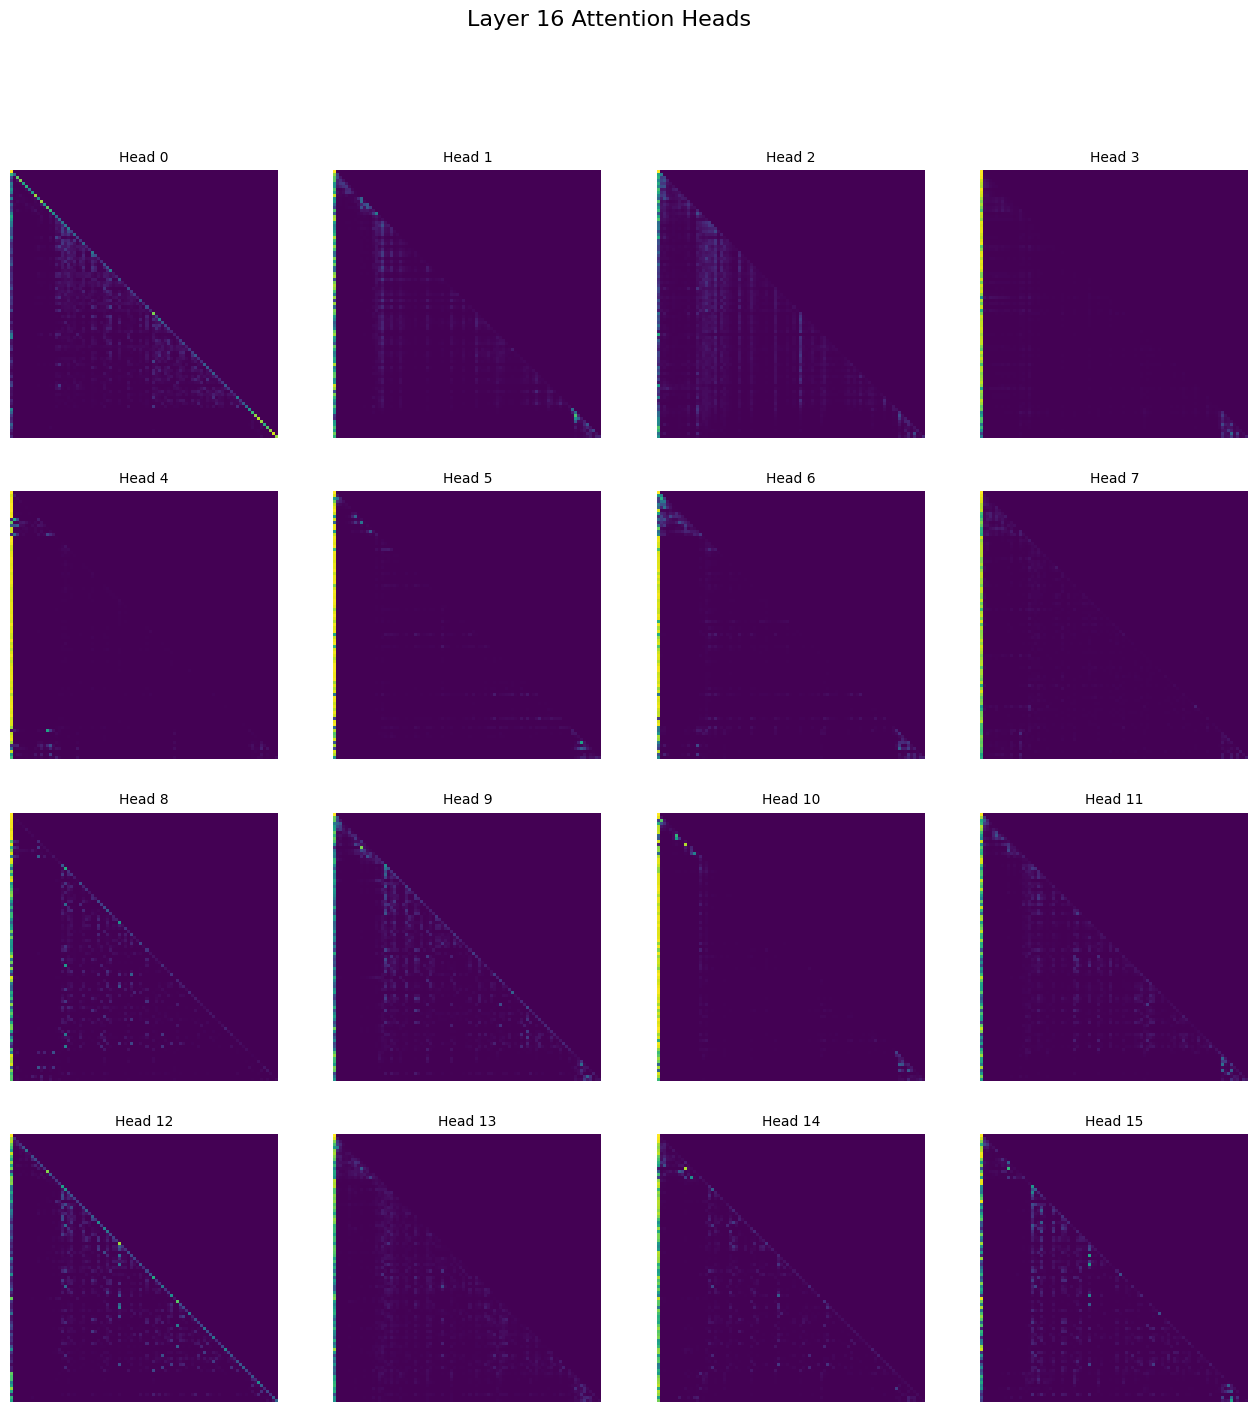

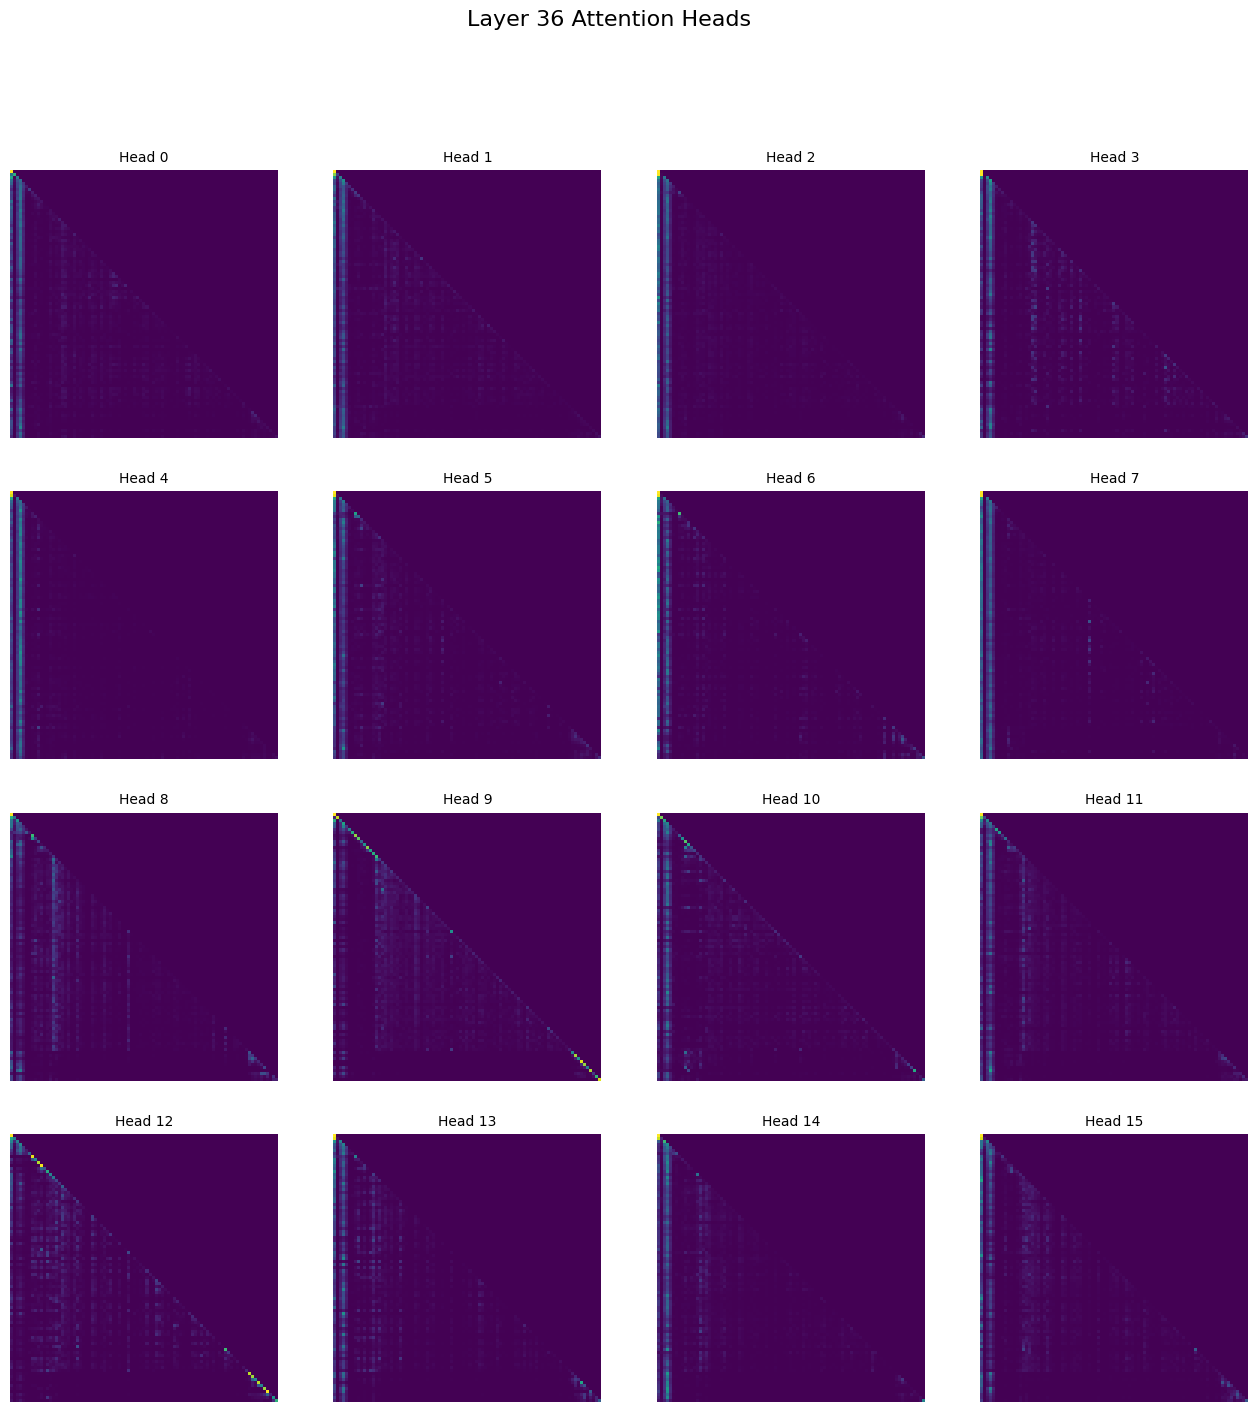

In [33]:
# แสดง attention map

# layer = attentions[-1]  # (batch, heads, tokens, tokens)
# fig, axs = plt.subplots(4, 4, figsize=(20, 20))
# for i, ax in enumerate(axs.flatten()):
#     ax.imshow(layer[0, i].detach().to('cpu', dtype=torch.float32).numpy())
#     ax.axis("off")

def visualize_attention_layer(attentions, layer_idx: int, nrows: int = 4, ncols: int = 4):
    layer = attentions[layer_idx]   # shape: (batch, heads, tokens, tokens)

    # เอา batch แรกมาดู
    batch0 = layer[0]

    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < batch0.shape[0]:  # เช็คว่า head มีพอไหม
            attn_head = batch0[i].detach().to("cpu", dtype=torch.float32).numpy()
            ax.imshow(attn_head)
            ax.set_title(f"Head {i}", fontsize=10)
        ax.axis("off")

    plt.suptitle(f"Layer {layer_idx + 1} Attention Heads", fontsize=16)
    plt.savefig(f"Attention Heads Layer {layer_idx + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()

for i in layer_idx_list:
    visualize_attention_layer(attentions, i)

#### Attention Rollout ของทุก layers

In [34]:
# ----------------------------
# 5) ทำ Attention Rollout (Aggregation)
#   - เพื่อให้เห็น focus รวมของทั้งโมเดล ไม่ใช่เฉพาะ 1 layer
# ----------------------------

def attention_rollout(attentions, force_fp32=True):
    first = attentions[0]
    B, H, T, _ = first.shape
    device = first.device

    dtype = torch.float32 if force_fp32 else first.dtype

    # ทำให้เป็น batch identity ตั้งแต่ต้น (เลี่ยง broadcast side-effects)
    rollout = torch.eye(T, dtype=dtype, device=device).expand(B, T, T).clone()

    for attn in attentions:
        A = attn.mean(dim=1).to(dtype)  # cast มาที่ float32
        I = torch.eye(T, dtype=dtype, device=device).expand(B, T, T)
        A = A + I
        A = A / (A.sum(dim=-1, keepdim=True) + 1e-6)
        rollout = rollout @ A

    return rollout

rollout_map = attention_rollout(attentions)

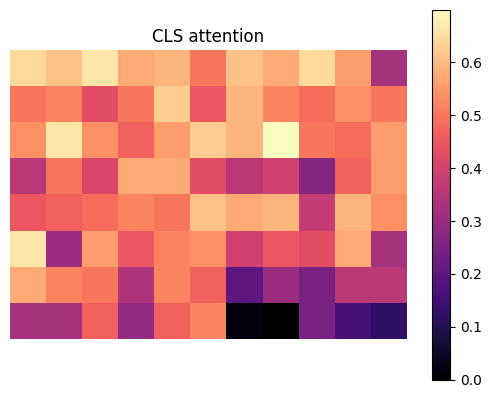

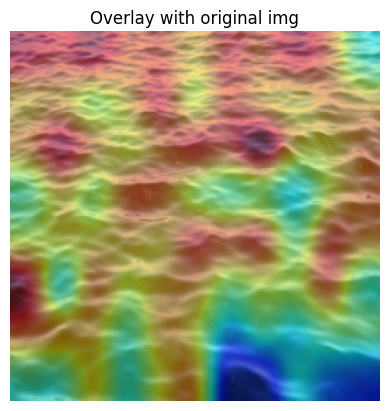

In [35]:
# ดึงค่า attention ของ [CLS] token → กระจายลง patch

num_patches = inputs["pixel_values"].size(-1)  # depends on patching
cls_attention = rollout_map[0, 1:, 0]
mat = cls_attention.detach().to('cpu', dtype=torch.float32).reshape(8, 11)
cls_attention = cls_attention.reshape(8, 11) # เพราะเรารู้ grid แน่นอนของภาพ

mat = (mat - mat.min()) / (mat.max() - mat.min() + 1e-6)

plt.imshow(mat.numpy(), cmap='magma', interpolation='nearest')
plt.title('CLS attention')
plt.colorbar()
plt.axis('off')
plt.savefig(f"CLS attention.png", dpi=300, bbox_inches="tight")
plt.show()

# Overlay กับภาพต้นฉบับ

from PIL import ImageFilter

cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
cls_attention = cls_attention.detach().to('cpu', dtype=torch.float32).numpy()
att_map = Image.fromarray((cls_attention * 255).astype(np.uint8)).resize(image.size, Image.BICUBIC)
att_map = att_map.filter(ImageFilter.GaussianBlur(2))

plt.imshow(image)
plt.imshow(att_map, cmap="jet", alpha=0.5)
plt.title('Overlay with original img')
plt.axis("off")
plt.savefig(f"Overlay with original img.png", dpi=300, bbox_inches="tight")
plt.show()

#### Attention Rollout ของ layer เดียว

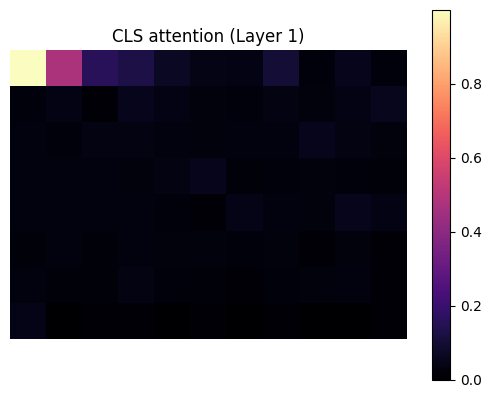

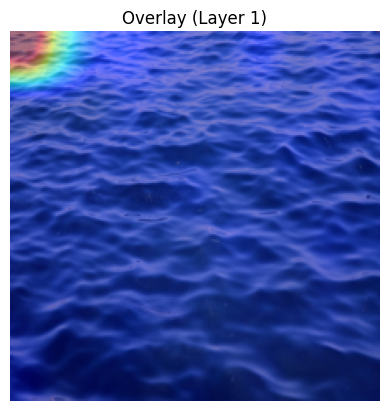

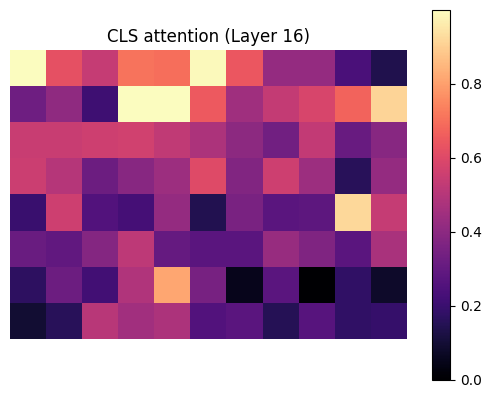

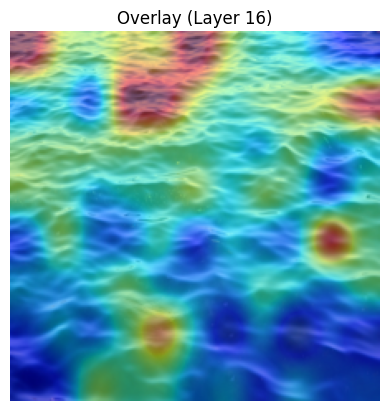

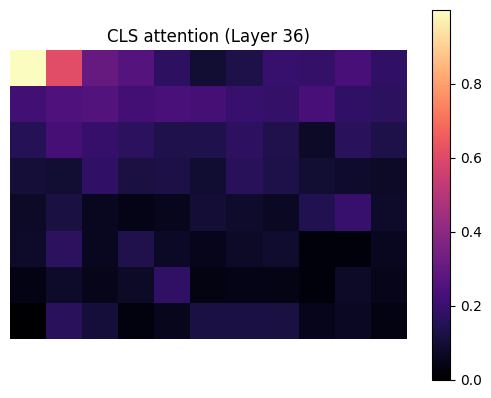

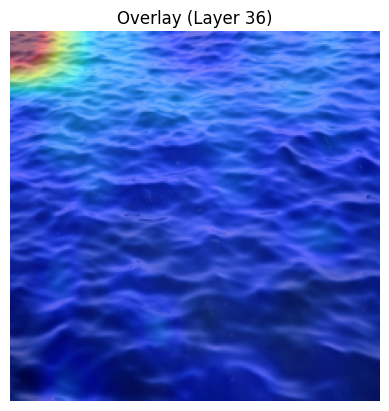

In [36]:
def attention_rollout_single(attentions, layer_idx: int, force_fp32=True):
    attn = attentions[layer_idx]   # (B, H, T, T)
    B, H, T, _ = attn.shape
    device = attn.device

    dtype = torch.float32 if force_fp32 else attn.dtype

    # เฉลี่ย head → (B, T, T)
    A = attn.mean(dim=1).to(dtype)

    # บวก identity เพื่อเลี่ยงการสูญเสีย self-connection
    I = torch.eye(T, dtype=dtype, device=device).expand(B, T, T)
    A = A + I

    # normalize per token
    A = A / (A.sum(dim=-1, keepdim=True) + 1e-6)

    return A

# เลือกเลเยอร์ i (เช่น index = 2)
for i in layer_idx_list:
    rollout_map = attention_rollout_single(attentions, i)

    # ดึง attention ของ [CLS] token → กระจายลง patch
    cls_attention = rollout_map[0, 1:, 0]   # batch=0, query=CLS=0
    grid_h, grid_w = 8, 11                  # ต้องรู้ patch grid
    mat = cls_attention.detach().to('cpu', dtype=torch.float32).reshape(grid_h, grid_w)

    # normalize
    mat = (mat - mat.min()) / (mat.max() - mat.min() + 1e-6)

    plt.imshow(mat.numpy(), cmap='magma', interpolation='nearest')
    plt.title(f'CLS attention (Layer {i + 1})')
    plt.colorbar()
    plt.axis('off')
    plt.savefig(f"CLS attention Layer {i + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Overlay กับภาพต้นฉบับ
    cls_attention = mat.numpy()
    att_map = Image.fromarray((cls_attention * 255).astype(np.uint8)).resize(image.size, Image.BICUBIC)
    att_map = att_map.filter(ImageFilter.GaussianBlur(2))

    plt.imshow(image)
    plt.imshow(att_map, cmap="jet", alpha=0.5)
    plt.title(f'Overlay (Layer {i + 1})')
    plt.axis("off")
    plt.savefig(f"Overlay Layer {i + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()

### Visualize Activation ของ Dense Layer

In [37]:
with torch.inference_mode():
    out = model(
        **inputs,
        output_hidden_states=True,   # <— สำคัญ
        return_dict=True,
        use_cache=False
    )

hidden_states = out.hidden_states
print(type(hidden_states))
print(len(hidden_states))
print(hidden_states)

<class 'tuple'>
37
(tensor([[[-0.0232,  0.0008, -0.0154,  ...,  0.0149,  0.0042,  0.0001],
         [-0.0308,  0.0371,  0.0289,  ..., -0.0188,  0.0061,  0.0212],
         [ 0.0330, -0.0216, -0.0021,  ..., -0.0209, -0.0210, -0.0383],
         ...,
         [-0.0232,  0.0008, -0.0154,  ...,  0.0149,  0.0042,  0.0001],
         [-0.0107, -0.0155, -0.0082,  ..., -0.0176,  0.0081,  0.0287],
         [ 0.0330, -0.0216, -0.0021,  ..., -0.0209, -0.0210, -0.0383]]],
       device='cuda:0', dtype=torch.bfloat16), tensor([[[ 0.1807,  0.3281,  0.1846,  ..., -0.7969,  0.3887,  0.0557],
         [-0.1504,  0.5859,  0.5156,  ...,  0.2988,  0.1602, -0.1660],
         [-0.3008,  0.0117,  0.0830,  ...,  0.1621,  0.2969, -0.3574],
         ...,
         [ 0.3008, -0.0189,  0.5391,  ..., -0.6484, -0.0020,  0.2754],
         [ 0.3613,  0.0439, -0.2256,  ..., -0.3145, -0.3008,  0.4766],
         [-0.0239, -0.1680,  0.1079,  ...,  0.1211,  0.1738, -0.1865]]],
       device='cuda:0', dtype=torch.bfloat16), te

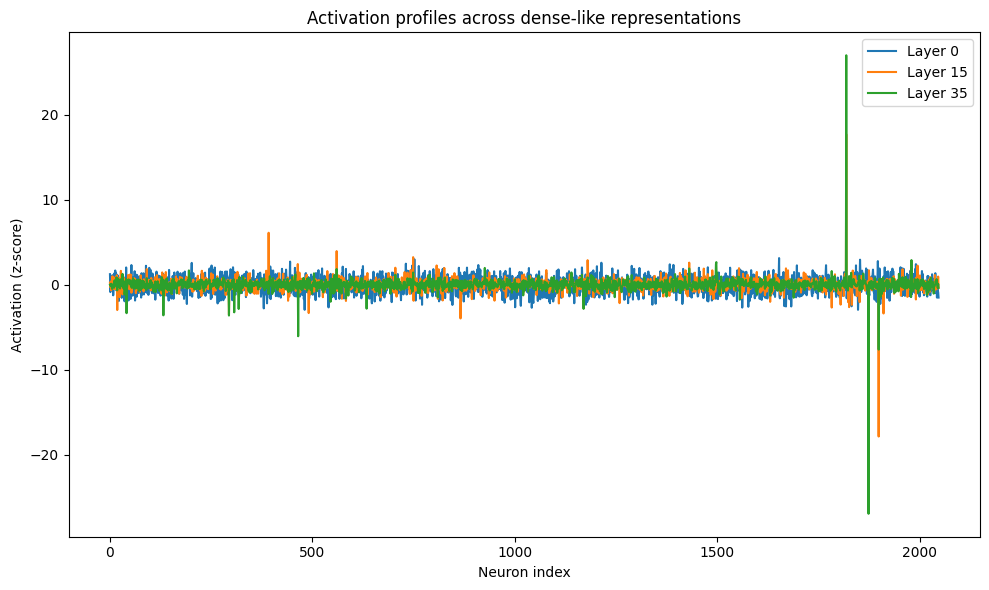

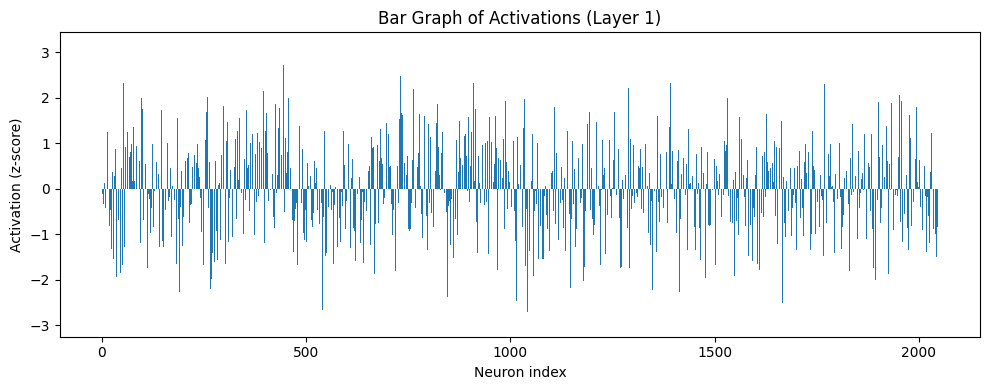

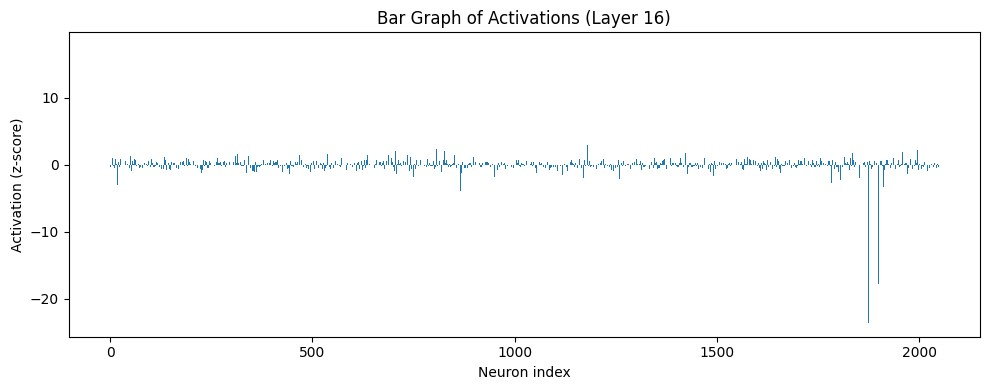

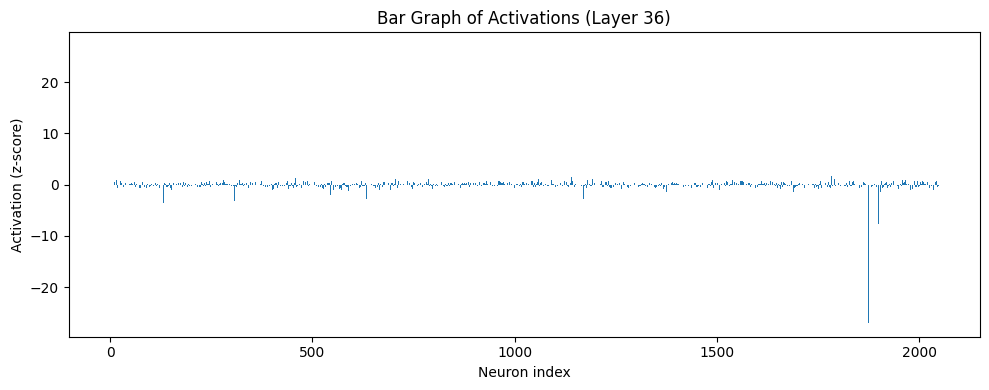

In [38]:
layers_to_show = [0, 15, 35]  # ตัวอย่าง 3 เลเยอร์
plt.figure(figsize=(10, 6))

for k, li in enumerate(layers_to_show, 1):
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)
    plt.plot(v, label=f"Layer {li}")

plt.title("Activation profiles across dense-like representations")
plt.xlabel("Neuron index")
plt.ylabel("Activation (z-score)")
plt.legend()
plt.tight_layout()
plt.savefig(f"Activation profiles across dense-like representations.png", dpi=300, bbox_inches="tight")
plt.show()

for li in layers_to_show:
    v = hidden_states[li][0, -1].detach().cpu().float().numpy()
    v = (v - v.mean()) / (v.std() + 1e-6)

    plt.figure(figsize=(10, 4))
    plt.bar(range(len(v)), v)
    plt.title(f"Bar Graph of Activations (Layer {li + 1})")
    plt.xlabel("Neuron index")
    plt.ylabel("Activation (z-score)")
    plt.tight_layout()
    plt.savefig(f"Bar Graph of Activations Layer {li + 1}.png", dpi=300, bbox_inches="tight")
    plt.show()